In [1]:
from elasticsearch import Elasticsearch, helpers
from pprint import pp
from dotenv import load_dotenv
import pandas as pd
from tqdm import tqdm
import os
load_dotenv()
#load_dotenv("elastic-start-local/.env")
ES_LOCAL_API_KEY = os.environ.get("ES_LOCAL_API_KEY")
ES_LOCAL_USER= os.environ.get("ES_LOCAL_USER")
ES_LOCAL_PASSWORD= os.environ.get("ES_LOCAL_PASSWORD")
ES_LOCAL_URL = os.environ.get("ES_LOCAL_URL")

def ppr(resp):
    pp(resp.raw)

In [2]:
def pretty_search_response(response):
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        for hit in response["hits"]["hits"]:
            id = hit["_id"]
            score = hit["_score"]
            body = hit["_source"]["Body"]
            comment_count = hit["_source"]["CommentCount"]
            creation_date = hit["_source"]["CreationDate"]

            pretty_output = f"\nID: {id}\nScore: {score}\nBody: {body}\nCommentCount: {comment_count}\nCreationDate: {creation_date}"

            print(pretty_output)

In [3]:
es = Elasticsearch([ES_LOCAL_URL], api_key=ES_LOCAL_API_KEY)

In [4]:
es = Elasticsearch(
    hosts=[
        ES_LOCAL_URL
    ],
    verify_certs=False,
)

In [5]:
if es.ping():
    print("Connected to Elasticsearch!")
else:
    print("Could not connect to Elasticsearch.")

Connected to Elasticsearch!


In [6]:
es.cat.health(v=True)

TextApiResponse('epoch      timestamp cluster           status node.total node.data shards pri relo init unassign unassign.pri pending_tasks max_task_wait_time active_shards_percent\n1734252472 08:47:52  es-docker-cluster green           3         3      6   6    0    0        0            0             0                  -                100.0%\n')

In [7]:
es.indices.delete(index='html_posts')

es.indices.create(
    index='html_posts',
    settings={
        "number_of_shards": 6,
        "number_of_replicas": 0,
        "analysis": {
            "analyzer": {
                "html_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "char_filter": [
                        "html_strip"
                    ]
                }
            }
        }
    }, 
    mappings={
        "properties": {
            "Body": {
                "type": "text",
                "analyzer": "html_analyzer"
            },
            "CommentCount": {
                "type": "integer"
            },
            "CreationDate": {
                "type": "date",
                "format": "yyyy-MM-dd HH:mm:ss.SSS"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'html_posts'})

In [8]:
def generator(json_chunk):
    for line in json_chunk:
        yield {
            "_index": "html_posts",
            "_id": line.get('Id'),
            "_source": {
                "Body": line.get("Body",""),
                "CommentCount": line.get("CommentCount",""),
                "CreationDate": line.get("CreationDate","")
            }
        }


def from_chunk_to_es(chunk):
    json_chunk = chunk.to_dict("records")
    return generator(json_chunk)

In [9]:
from matplotlib import animation
from matplotlib import pyplot as plt
columns = ['Id', 'Body', 'CommentCount', "CreationDate"]

for chunk in tqdm(pd.read_csv('../data/StackOverflowMini_dbo_Posts.csv', chunksize=1000)):
    gen = from_chunk_to_es(chunk[columns])
    res = helpers.bulk(es, gen)

1566it [02:03, 12.73it/s]


In [10]:
print(list(es.nodes.stats()['nodes'].values())[2]['indices'])

{'docs': {'count': 508626, 'deleted': 0, 'total_size_in_bytes': 356398904}, 'shard_stats': {'total_count': 2}, 'store': {'size_in_bytes': 362759669, 'total_data_set_size_in_bytes': 362759669, 'reserved_in_bytes': 0}, 'indexing': {'index_total': 1567392, 'index_time_in_millis': 130707, 'index_current': 0, 'index_failed': 0, 'delete_total': 0, 'delete_time_in_millis': 0, 'delete_current': 0, 'noop_update_total': 0, 'is_throttled': False, 'throttle_time_in_millis': 0, 'write_load': 0.04884564405932249}, 'get': {'total': 0, 'time_in_millis': 0, 'exists_total': 0, 'exists_time_in_millis': 0, 'missing_total': 0, 'missing_time_in_millis': 0, 'current': 0}, 'search': {'open_contexts': 0, 'query_total': 0, 'query_time_in_millis': 0, 'query_current': 0, 'query_failure': 0, 'fetch_total': 0, 'fetch_time_in_millis': 0, 'fetch_current': 0, 'fetch_failure': 0, 'scroll_total': 0, 'scroll_time_in_millis': 0, 'scroll_current': 0, 'suggest_total': 0, 'suggest_time_in_millis': 0, 'suggest_current': 0}, '

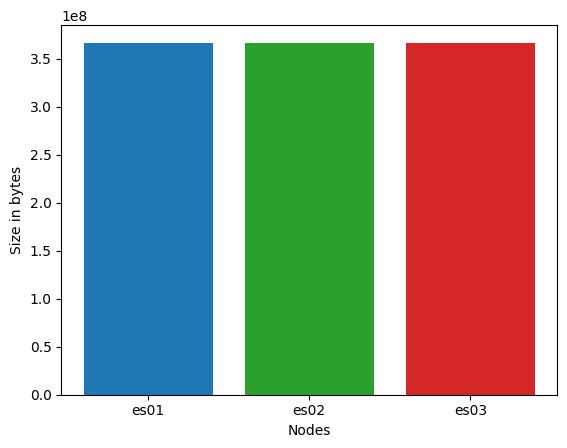

In [18]:
import matplotlib.pyplot as plt
plt.style.use("default")

counts = []
sizes = []
colors = ['tab:blue', 'tab:green', 'tab:red']
for node in es.nodes.stats()['nodes'].values():
    counts.append(node['indices']['docs']['count'])
    sizes.append(node['indices']['docs']['total_size_in_bytes'])

plt.bar(x=["es01", "es02", "es03"], height=sizes, color=colors)
plt.xlabel("Nodes")
plt.ylabel("Size in bytes")
plt.savefig("load_balancing.png")
plt.show()

In [12]:
# effects of analyzer
resp = es.search(
    index="html_posts",
    size="3",
    query={
        "match": {
            "Body": {
                "query": "Python"
            }
        }
    }
)

pretty_search_response(resp)

resp = es.search(
    index="html_posts",
    size="1",
    query={
        "match": {
            "Body": {
                "query": "<p>"
            }
        }
    }
)

pretty_search_response(resp)


ID: 884652
Score: 8.397677
Body: <p>It works for me (it gets the total number of 'string here' found in each file). However, it does not display the total for ALL files searched. Here is how you can get it:</p>

<pre><code>grep -c -r 'string' file &gt; out &amp;&amp; \
    awk -F : '{total += $2} END { print "Total:", total }' out
</code></pre>

<p>The list will be in out and the total will be sent to STDOUT.</p>

<p>Here is the output on the Python2.5.4 directory tree:</p>

<pre><code>grep -c -r 'import' Python-2.5.4/ &gt; out &amp;&amp; \
    awk -F : '{total += $2} END { print "Total:", total }' out
Total: 11500

$ head out
Python-2.5.4/Python/import.c:155
Python-2.5.4/Python/thread.o:0
Python-2.5.4/Python/pyarena.c:0
Python-2.5.4/Python/getargs.c:0
Python-2.5.4/Python/thread_solaris.h:0
Python-2.5.4/Python/dup2.c:0
Python-2.5.4/Python/getplatform.c:0
Python-2.5.4/Python/frozenmain.c:0
Python-2.5.4/Python/pyfpe.c:0
Python-2.5.4/Python/getmtime.c:0
</code></pre>

<p>If you just want